In [1]:
using FileIO
using CSV
using DataFrames
using LinearAlgebra
using Statistics
using Glob
using Parameters
using Plots

#=
df = DataFrame(results)
df = DataFrame(Matrix(df)')
rename!(df, :x1 => :scenario_id, :x2 => :ego_v, :x3 => :hit_point, :x4 => :collision, :x5 => :eb_intervention)
rename!(df, :x6 => :dv_collision, :x7 => :v_mean, :x8 => :a_mean, :x9 => :a_jerk, :x10 => :a_min)

CSV.write(log_filename, df);
=#

In [2]:
@with_kw mutable struct ScenarioResult 
    filename::String = "filename"
    algorithm::String = "algorithm"
    policy::String = "policy"
    collision_cost::Float64 = 0.
    probability_pedestrian_birth::Float64 = 0.
    action_lon_cost::Float64 = 0.
    action_lat_cost::Float64 = 0.
    keep_velocity_reward::Float64 = 0.
    keep_lane_reward::Float64 = 0.
    
    
    sum_scenarios::Int = 0
    sum_collisions::Int = 0
    sum_emergency_brake_interventions::Int = 0
    dv::Float64 = 0.
    v_mean::Float64 = 0.
    a_mean::Float64 = 0.
    a_jerk::Float64 = 0.
    a_min::Float64 = 0.
end

ScenarioResult

In [12]:


function evaluate_file(filename)
    
    result = ScenarioResult()
    result.filename = filename
    file_name_parameters = split(filename,'_')
    collision_cost = 0.
    probability_pedestrian_birth = 0.
    action_lon_cost = 0.
    action_lat_cost = 0.
    keep_velocity_reward = 0.
    if ( file_name_parameters[2] != "EmergencyBrakingSystem")
                
        if ( file_name_parameters[3] == "EmergencyBrakingSystem")
            result.algorithm = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem" 
            result.policy = file_name_parameters[4]
            result.collision_cost = parse(Float64, file_name_parameters[5])
            result.probability_pedestrian_birth = parse(Float64, file_name_parameters[6])
            result.action_lon_cost = parse(Float64, file_name_parameters[7])
            result.action_lat_cost = parse(Float64, file_name_parameters[8])
            result.keep_velocity_reward = parse(Float64, file_name_parameters[9])
            try
                result.keep_lane_reward = parse(Float64, file_name_parameters[10])
            catch
                
            end

        else
            result.algorithm = "PedestrianAvoidancePOMDP" 
            result.policy = file_name_parameters[3]
            result.collision_cost = parse(Float64, file_name_parameters[4])
            result.probability_pedestrian_birth = parse(Float64, file_name_parameters[5])
            result.action_lon_cost = parse(Float64, file_name_parameters[6])
            result.action_lat_cost = parse(Float64, file_name_parameters[7])
            result.keep_velocity_reward = parse(Float64, file_name_parameters[8])
            try
                result.keep_lane_reward = parse(Float64, file_name_parameters[9])
            catch
                
            end

            
        end
    else
        result.algorithm = "EmergencyBrakingSystem" 
    end


    dv = []
    v_mean = []
    a_mean = []
    a_jerk = []
    a_min = []

    for row in CSV.File(filename)
        #println(row.v_mean)
        push!(dv, row.v_mean)
        push!(v_mean, row.v_mean)
        push!(a_mean, row.a_mean)
        push!(a_jerk, row.a_jerk)
        push!(a_min, row.a_min)
        result.sum_collisions += row.collision
        result.sum_emergency_brake_interventions += row.eb_intervention
        #println("a=$(row.a), b=$(row.b), c=$(row.c)")
        result.sum_scenarios += 1
    end

    result.dv = mean(dv)
    result.v_mean = mean(v_mean)
    result.a_mean = mean(a_mean)
    result.a_jerk = mean(a_jerk)
    result.a_min = mean(a_min)


    return result
end


evaluate_file (generic function with 1 method)

In [13]:
files = glob("results_EmergencyBrakingSystem_*.csv")

results = []
for file_name in files
    result = evaluate_file(file_name) 
    println(result)
    push!(results, result)
end

ScenarioResult
  filename: String "results_EmergencyBrakingSystem_no_-500.0_0.6_-1.0_-1.0_5.0_.jld2.csv"
  algorithm: String "EmergencyBrakingSystem"
  policy: String "policy"
  collision_cost: Float64 0.0
  probability_pedestrian_birth: Float64 0.0
  action_lon_cost: Float64 0.0
  action_lat_cost: Float64 0.0
  keep_velocity_reward: Float64 0.0
  keep_lane_reward: Float64 0.0
  sum_scenarios: Int64 26
  sum_collisions: Int64 3
  sum_emergency_brake_interventions: Int64 24
  dv: Float64 12.095090684754608
  v_mean: Float64 12.095090684754608
  a_mean: Float64 -8.655748098055792
  a_jerk: Float64 17.307692307692307
  a_min: Float64 -9.23076923076923



In [74]:
files = glob("results_PedestrianAvoidancePOMDP_policy*.csv")
#files = glob("results_PedestrianAvoidancePOMDP_EmergencyBrakingSystem_policy*.csv")

files = glob("results_PedestrianAvoidancePOMDP_longitudinal*.csv", "longitudinalnew" )
files = glob("results_PedestrianAvoidancePOMDP_EmergencyBrakingSystem_longitudinal*.csv", "longitudinalnew" )

results = []
for file_name in files
    result = evaluate_file(file_name) 
   # println(result)
    push!(results, result)
end
length(results)

80

In [77]:

actionloncost = [0., -1., -2., -3.]
keepvelocityreward = [0., 5., 10., 15.]
id_matrix = zeros(Int64, length(actionloncost), length(keepvelocityreward))

for i=1:length(results)
    result = results[i]
    if result.probability_pedestrian_birth == 0.5
        id_action_lon_cost = findall(x->x == result.action_lon_cost, actionloncost)
        id_keep_velocity_reward = findall(x->x == result.keep_velocity_reward, keepvelocityreward )
        id_matrix[id_action_lon_cost[1],id_keep_velocity_reward[1]] = i 
    end
end
id_matrix

4×4 Array{Int64,2}:
 13  16  14  15
  1   4   2   3
  5   8   6   7
  9  12  10  11

0.0
collisions: Any[0, 0, 0, 0]
sum_emergency_brake_interventions: Any[3, 3, 20, 21]
Any[6.57848, 7.28527, 10.488, 10.5838]
----
5.0
collisions: Any[3, 2, 1, 4]
sum_emergency_brake_interventions: Any[6, 10, 12, 13]
Any[8.26668, 8.65427, 9.77434, 10.2238]
----
10.0
collisions: Any[3, 3, 3, 4]
sum_emergency_brake_interventions: Any[7, 9, 11, 9]
Any[7.84813, 8.61773, 9.73616, 9.52815]
----
15.0
collisions: Any[2, 3, 3, 2]
sum_emergency_brake_interventions: Any[8, 7, 10, 11]
Any[7.78756, 8.23354, 9.53695, 9.638]
----


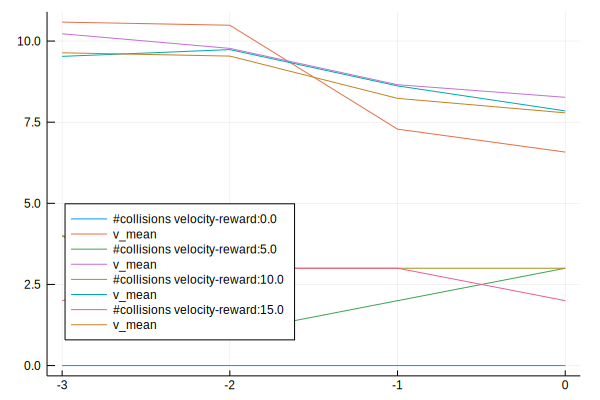

In [80]:
# evaluation based on action lon cost

#println(actionloncost)

p = plot()
k = plot()

for i = 1:length(keepvelocityreward)
    sum_collisions = []
    sum_emergency_brake_interventions = []
    dv = []
    v_mean = []
    a_mean = []
    a_jerk = []
    a_min = []
    for id in id_matrix[:,i]
        #println(id)
        push!(sum_collisions, results[id].sum_collisions)
        push!(sum_emergency_brake_interventions, results[id].sum_emergency_brake_interventions)
        push!(dv, results[id].dv)  
        push!(v_mean, results[id].v_mean)
        push!(a_mean, results[id].a_mean)
        push!(a_jerk, results[id].a_jerk)
        push!(a_min, results[id].a_min)
        if ( results[id].v_mean > 7.5 && results[id].sum_collisions == 0)
           # println(id)
          #  println(results[id])
        end
    end
    println(keepvelocityreward[i])
    println("collisions: ", sum_collisions)
    println("sum_emergency_brake_interventions: ", sum_emergency_brake_interventions)

    println(v_mean)
   println("----")

    plot!(actionloncost, sum_collisions, label=string("#collisions velocity-reward:", keepvelocityreward[i]) )
  #  plot!(actionloncost, sum_emergency_brake_interventions, label="#brake_interventions" )
  #  plot!(actionloncost, a_mean, label="a_mean" )

   # plot!(actionloncost, a_jerk, label="a_jerk" )
    plot!(actionloncost, v_mean, label="v_mean" )
end

plot!(legend=:bottomleft)

[0.0, 2.0, 4.0, 6.0, 8.0]
Any[7.83538, 7.30803, 7.51153, 7.43411, 8.23186]
Any[0, 0, 0, 0, 0]
----
[0.0, 2.0, 4.0, 6.0, 8.0]
Any[7.91271, 7.89658, 7.99453, 8.01521, 8.22148]
Any[0, 0, 0, 0, 0]
----
[0.0, 2.0, 4.0, 6.0, 8.0]
Any[10.0185, 10.0083, 10.1117, 10.2676, 10.6377]
Any[0, 0, 0, 1, 0]
----
[0.0, 2.0, 4.0, 6.0, 8.0]
Any[10.1326, 10.8281, 11.3549, 11.4856, 11.5061]
Any[0, 0, 0, 2, 2]
----


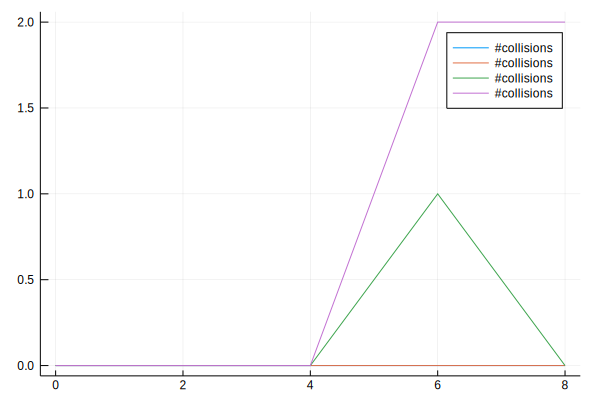

In [17]:
#println(keepvelocityreward)

plot()

for i = 1:length(actionloncost)
    #println(i)
    sum_collisions = []
    sum_emergency_brake_interventions = []
    dv = []
    v_mean = []
    a_mean = []
    a_jerk = []
    a_min = []
    for id in id_matrix[i,:]
        #println(id)
        #println(results[id])
        push!(sum_collisions, results[id].sum_collisions)
        push!(sum_emergency_brake_interventions, results[id].sum_emergency_brake_interventions)
        push!(dv, results[id].dv)  
        push!(v_mean, results[id].v_mean)
        push!(a_mean, results[id].a_mean)
        push!(a_jerk, results[id].a_jerk)
        push!(a_min, results[id].a_min)
    end
    println(keepvelocityreward)
    println(v_mean)
    println(sum_collisions)

    println("----")
    plot!(keepvelocityreward, sum_collisions, label="#collisions" )
   # plot!(keepvelocityreward, sum_emergency_brake_interventions, label="#brake_interventions" )
   # plot!(keepvelocityreward, a_mean, label="a_mean" )
   # plot!(keepvelocityreward, a_jerk, label="a_jerk" )
   # plot!(keepvelocityreward, v_mean, label="v_mean" )
end

plot!()

In [182]:
id_matrix#[5,:]

4×5 Array{Int64,2}:
 16  17  18  19  20
  1   2   3   4   5
  6   7   8   9  10
 11  12  13  14  15

In [192]:
id_matrix[:,5]

4-element Array{Int64,1}:
 20
  5
 10
 15

MethodError: MethodError: Cannot `convert` an object of type Int64 to an object of type Array{Array{Float64,N} where N,N} where N
Closest candidates are:
  convert(::Type{Array{T,N} where N}, !Matched::StaticArrays.SizedArray{S,T,N,M} where M where N) where {T, S} at /home/xubuntu/.julia/packages/StaticArrays/3ENSR/src/SizedArray.jl:79
  convert(::Type{T<:Array}, !Matched::AbstractArray) where T<:Array at array.jl:489
  convert(::Type{T<:AbstractArray}, !Matched::T<:AbstractArray) where T<:AbstractArray at abstractarray.jl:14
  ...

In [22]:
files = glob("results_PedestrianAvoidancePOMDP_lateral*.csv", "lateral")
files = glob("results_PedestrianAvoidancePOMDP_EmergencyBrakingSystem_lateral*.csv", "lateral")

results = []
for file_name in files
    result = evaluate_file(file_name) 
   # println(result)
    push!(results, result)
end
length(results)

25

In [34]:
actionlatcost = [0., -2., -4., -6., -8.]
keeplanereward = [0., 2., 4., 6., 8.]

id_matrix = zeros(Int64, length(actionlatcost), length(keeplanereward))

for i=1:length(results)
    result = results[i]
    if result.probability_pedestrian_birth == 0.6
        id_action_lat_cost = findall(x->x == result.action_lat_cost, actionlatcost)
        id_lane_reward = findall(x->x == result.keep_lane_reward, keeplanereward )
        id_matrix[id_action_lat_cost[1],id_lane_reward[1]] = i 
    end
end
id_matrix


5×5 Array{Int64,2}:
 21  22  23  24  25
  1   2   3   4   5
  6   7   8   9  10
 11  12  13  14  15
 16  17  18  19  20

Any[0, 0, 0, 0, 0]
Any[7.881, 7.33616, 7.68961, 7.3695, 7.47674]
Any[0, 0, 0, 0, 0]
Any[6.97353, 7.2198, 7.77709, 7.54775, 7.26979]
Any[0, 0, 0, 0, 0]
Any[7.72706, 7.22585, 7.2704, 7.44612, 7.83165]
Any[0, 0, 0, 0, 0]
Any[7.22086, 7.49322, 7.46161, 7.06787, 7.08398]
Any[0, 0, 0, 0, 0]
Any[7.09333, 7.28927, 7.33203, 7.10738, 7.24009]


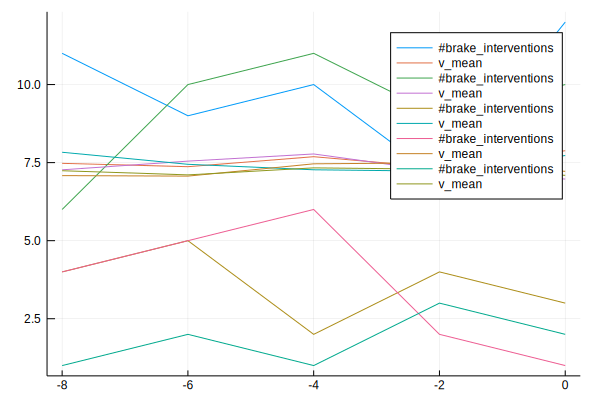

In [36]:
# evaluation based on action lat cost

#println(actionlatcost)

p = plot()
k = plot()

for i = 1:length(keeplanereward)
    sum_collisions = []
    sum_emergency_brake_interventions = []
    dv = []
    v_mean = []
    a_mean = []
    a_jerk = []
    a_min = []
    for id in id_matrix[:,i]
        #println(id)
        push!(sum_collisions, results[id].sum_collisions)
        push!(sum_emergency_brake_interventions, results[id].sum_emergency_brake_interventions)
        push!(dv, results[id].dv)  
        push!(v_mean, results[id].v_mean)
        push!(a_mean, results[id].a_mean)
        push!(a_jerk, results[id].a_jerk)
        push!(a_min, results[id].a_min)
    end
 #   println(actionloncost)
    println(sum_collisions)
    println(v_mean)
 #   println("----")

    #plot!(actionlatcost, sum_collisions, label="#collisions" )
    plot!(actionlatcost, sum_emergency_brake_interventions, label="#brake_interventions" )
   # plot!(actionlatcost, a_mean, label="a_mean" )

   # plot!(actionlatcost, a_jerk, label="a_jerk" )
    plot!(actionlatcost, v_mean, label="v_mean" )
end

plot!()